# Analyse des cartes HiC correspondant au métagénome du kéfir

## 0. Objectif

recherche de bactériophages visibles sur les cartes HiC

## 1. Environnement et données

**libraries**

In [1]:
import sys
import os
import csv

import numpy as np
from scipy.spatial import ConvexHull
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt

import HiCtoolbox
import sammon

**Fichiers**

sorties de hicstuff : 
- abs_fragments_contacts_weighted = ligne, colonne, et valeur des pixels qui sont != 0 -> les lignes et colonnes correspondent aux numéros des deux fragments qui se touchent, et la valeur au nombre relatif de contacts
- fragments_list = liste de tous les fragments (de longueur 100) composant les échantillons illumina
- info_contigs = liste et longueur de tous les contigs du métagénome

metagenome_ncbi_id = fichier d'équivalence nom et numéro d'espèce (de forme BX)

datas_phaster = fichier phaster contenant les informations sur les génomes de phages retrouvés dans les bactéries du métagénome


In [21]:

PATH = "/home/eliotttempez/Documents/tests/phages/HiC/hicstuff_minimap/"
matrix_name = PATH + 'abs_fragments_contacts_weighted.txt'
frag_name = PATH + 'fragments_list.txt'
ctg_name = PATH + 'info_contigs.txt'

sp_name = '/home/eliotttempez/Documents/routines/phages/metagenome_ncbi_id.txt'

phaster_name = '/home/eliotttempez/Documents/tests/phages/phaster/datas_phaster.csv'

In [31]:
## matrice de contacts
matrix = pd.read_csv(matrix_name, delimiter = '\t', header = 0, names = ["row", "column", "values"])
print(matrix)

              row   column  values
0             390      391       1
1            7375     7376       1
2           19918    19919       1
3           24711   134152       1
4           24711   724441       1
...           ...      ...     ...
20299303  1034868  1034868       5
20299304  1034868  1034869       8
20299305  1034871  1034874       1
20299306  1034874  1034875       2
20299307  1034875  1034875      10

[20299308 rows x 3 columns]


In [35]:
## liste des fragments
frag = pd.read_csv(frag_name, delimiter = '\t', header = 0, names = ["id", "chrom", "start_pos", "end_pos", "size", "gc_content"])
# Add a column with unique identifier
frag['ID'] = range(len(frag))

print(frag)

         id                             chrom  start_pos  end_pos  size  \
0         1  B10_contig_2|kraken:taxid|152331          0      100   100   
1         2  B10_contig_2|kraken:taxid|152331        100      200   100   
2         3  B10_contig_2|kraken:taxid|152331        200      300   100   
3         4  B10_contig_2|kraken:taxid|152331        300      400   100   
4         5  B10_contig_2|kraken:taxid|152331        400      500   100   
...      ..                               ...        ...      ...   ...   
1034873  12  Y3_scaffold_23|kraken:taxid|4926       1100     1200   100   
1034874  13  Y3_scaffold_23|kraken:taxid|4926       1200     1300   100   
1034875  14  Y3_scaffold_23|kraken:taxid|4926       1300     1400   100   
1034876  15  Y3_scaffold_23|kraken:taxid|4926       1400     1500   100   
1034877  16  Y3_scaffold_23|kraken:taxid|4926       1500     1506     6   

         gc_content    index  
0          0.002200        0  
1          0.002700        1  
2     

In [38]:
## Liste des  contigs
ctg = pd.read_csv(ctg_name, delimiter = '\t', header = 0, names = ["chrom", "length", "n_frags", "cumul_length"])
# Add a column with unique identifier
ctg["index"] = range(len(ctg))

print(ctg)

                                chrom   length  n_frags  cumul_length  index
0    B10_contig_2|kraken:taxid|152331    15138      152             0      0
1    B10_contig_1|kraken:taxid|152331  2454889    24549           152      1
2    B10_contig_3|kraken:taxid|152331    84524      846         24701      2
3     B11_contig_11|kraken:taxid|1597    11019      111         25547      3
4      B11_contig_1|kraken:taxid|1597     2246       23         25658      4
..                                ...      ...      ...           ...    ...
251  Y3_scaffold_19|kraken:taxid|4926     3352       34       1034764    251
252  Y3_scaffold_20|kraken:taxid|4926     2601       27       1034798    252
253  Y3_scaffold_21|kraken:taxid|4926     2030       21       1034825    253
254  Y3_scaffold_22|kraken:taxid|4926     1531       16       1034846    254
255  Y3_scaffold_23|kraken:taxid|4926     1506       16       1034862    255

[256 rows x 5 columns]


In [39]:
## Liste des espèces
sp = pd.read_csv(sp_name, delimiter = "\t", names = ["sp_nb", "id", "species", "type"])
# ne garder que les colonnes pertinentes
sp = sp[['sp_nb', 'species']]

print(sp)

   sp_nb                              species
0     B3                  Acetobacter fabarum
1     B4                Gluconobacter albidus
2     B6                Gluconobacter cerinus
3     B1                Gluconobacter oxydans
4     B5             Komagataeibacter xylinus
5     B2               Novacetimonas hansenii
6    B11         Lacticaseibacillus paracasei
7    B18         Lentilactobacillus hilgardii
8    B10      Lentilactobacillus parabuchneri
9     B7            Leuconostoc mesenteroides
10   B14       Liquorilactobacillus ghanensis
11   B13         Liquorilactobacillus nagelii
12   B17     Liquorilactobacillus satsumensis
13   B21                   Oenococcus sicerae
14   B12  Schleiferilactobacillus harbinensis
15    BB           Brettanomyces bruxellensis
16    Y3               Pichia membranifaciens
17    Y1             Saccharomyces cerevisiae
18    Y2           Zygotorulaspora florentina
19   B16                    Zymomonas mobilis
20   B15                 Oenococcu

In [40]:

## Liste des génomes viraux
phaster_brut = pd.read_csv(phaster_name, delimiter = "\t", header = 0, names = ["mcf", "species", "region", "region_lg", "completeness", "contig_assembly", "score", "proteins", "position", "phage", "gc", "filename", "nan"])

# adaptation des données
# supprimer les lignes/colonnes inutiles
temp = phaster_brut[['species', 'region', 'completeness', 'position', 'phage']]
temp = temp.iloc[1:, :]
# nettoyer les str 
temp_obj = temp.select_dtypes('object')
temp[temp_obj.columns] = temp_obj.apply(lambda x: x.str.strip())
temp['species'] = temp['species'].str.replace("_", " ")
temp['species'] = temp['species'].ffill()

phaster = temp[temp['phage'].notna()]

print(phaster)

                                 species  region  completeness  \
2                    Acetobacter fabarum     1.0    incomplete   
3                    Acetobacter fabarum     2.0    incomplete   
5                  Gluconobacter albidus     1.0  questionable   
6                  Gluconobacter albidus     2.0    incomplete   
8                  Gluconobacter albidus     NaN    incomplete   
..                                   ...     ...           ...   
101  Schleiferilactobacillus harbinensis     2.0  questionable   
102  Schleiferilactobacillus harbinensis     3.0    incomplete   
104  Schleiferilactobacillus harbinensis     4.0    incomplete   
106  Schleiferilactobacillus harbinensis     5.0    incomplete   
108  Schleiferilactobacillus harbinensis     6.0        intact   

            position                                 phage  
2    2471390-2485480       PHAGE_Entero_Sf101_NC_027398(2)  
3    2815815-2828617  PHAGE_Aeromo_vB_AsaM_56_NC_019527(6)  
5      870653-894182    

## 2. Matrice globale du consortium

In [42]:
# function which extracts a submatrix for a given contig from 2 global matrix and frag files
def make_submat(matrix, frag):
    toselect = frag.ID
    tmp0 = matrix.loc[matrix['row'] > min(toselect)]
    tmp1=tmp0.loc[tmp0['row'] < max(toselect)]
    tmp2=tmp1.loc[tmp1['column'] > min(toselect)]
    submat=tmp2.loc[tmp2['column'] < max(toselect)]
    submat.loc[:,'row']=submat.loc[:,'row'] - min(toselect)
    submat.loc[:,'column']=submat.loc[:,'column'] - min(toselect)
    return(submat)

submat=make_submat(matrix, frag)
print(submat)

              row   column  values
0             390      391       1
1            7375     7376       1
2           19918    19919       1
3           24711   134152       1
4           24711   724441       1
...           ...      ...     ...
20299303  1034868  1034868       5
20299304  1034868  1034869       8
20299305  1034871  1034874       1
20299306  1034874  1034875       2
20299307  1034875  1034875      10

[20299308 rows x 3 columns]


In [5]:
def get_species(sequence):
    species=sequence.split("_")[0]
    return(species)

frag['sp_nb']=frag['chrom'].map(get_species)
frag = frag.merge(sp[['sp_nb', 'species']], on = "sp_nb")
print(frag)

         id                             chrom  start_pos  end_pos  size  \
0         1  B10_contig_2|kraken:taxid|152331          0      100   100   
1         2  B10_contig_2|kraken:taxid|152331        100      200   100   
2         3  B10_contig_2|kraken:taxid|152331        200      300   100   
3         4  B10_contig_2|kraken:taxid|152331        300      400   100   
4         5  B10_contig_2|kraken:taxid|152331        400      500   100   
...      ..                               ...        ...      ...   ...   
1034873  12  Y3_scaffold_23|kraken:taxid|4926       1100     1200   100   
1034874  13  Y3_scaffold_23|kraken:taxid|4926       1200     1300   100   
1034875  14  Y3_scaffold_23|kraken:taxid|4926       1300     1400   100   
1034876  15  Y3_scaffold_23|kraken:taxid|4926       1400     1500   100   
1034877  16  Y3_scaffold_23|kraken:taxid|4926       1500     1506     6   

         gc_content       ID sp_nb                          species  
0          0.002200        0 

In [6]:
def get_species(sequence):
    species=sequence.split("_")[0]
    return(species)

ctg['sp_nb']=ctg['chrom'].map(get_species)
ctg = ctg.merge(sp[['sp_nb', 'species']], on = "sp_nb")
print(ctg)

                                chrom   length  n_frags  cumul_length  index  \
0    B10_contig_2|kraken:taxid|152331    15138      152             0      0   
1    B10_contig_1|kraken:taxid|152331  2454889    24549           152      1   
2    B10_contig_3|kraken:taxid|152331    84524      846         24701      2   
3     B11_contig_11|kraken:taxid|1597    11019      111         25547      3   
4      B11_contig_1|kraken:taxid|1597     2246       23         25658      4   
..                                ...      ...      ...           ...    ...   
251  Y3_scaffold_19|kraken:taxid|4926     3352       34       1034764    251   
252  Y3_scaffold_20|kraken:taxid|4926     2601       27       1034798    252   
253  Y3_scaffold_21|kraken:taxid|4926     2030       21       1034825    253   
254  Y3_scaffold_22|kraken:taxid|4926     1531       16       1034846    254   
255  Y3_scaffold_23|kraken:taxid|4926     1506       16       1034862    255   

    sp_nb                          spec

In [7]:
tab = pd.DataFrame(pd.unique(ctg['species']), columns=['species'] )

print(tab)

                                species
0       Lentilactobacillus parabuchneri
1          Lacticaseibacillus paracasei
2   Schleiferilactobacillus harbinensis
3          Liquorilactobacillus nagelii
4        Liquorilactobacillus ghanensis
5      Liquorilactobacillus satsumensis
6          Lentilactobacillus hilgardii
7                 Gluconobacter oxydans
8                    Oenococcus sicerae
9                Novacetimonas hansenii
10                  Acetobacter fabarum
11                Gluconobacter albidus
12             Komagataeibacter xylinus
13                Gluconobacter cerinus
14            Leuconostoc mesenteroides
15           Brettanomyces bruxellensis
16             Saccharomyces cerevisiae
17           Zygotorulaspora florentina
18               Pichia membranifaciens


In [8]:
def get_chromlength(chrom_name):
    lenK=min(ctg[ctg['species']==chrom_name]['cumul_length'])
    return(lenK)

tab['genome_len'] = tab['species'].map(get_chromlength)
tab['genome_len_bin'] = np.round(tab['genome_len']/1000)
tab['genome_len_nucl'] = test = ctg.groupby('species', as_index=False)['length'].sum()['length']

print(tab)


                                species  genome_len  genome_len_bin  \
0       Lentilactobacillus parabuchneri           0             0.0   
1          Lacticaseibacillus paracasei       25547            26.0   
2   Schleiferilactobacillus harbinensis       59340            59.0   
3          Liquorilactobacillus nagelii       91855            92.0   
4        Liquorilactobacillus ghanensis      117246           117.0   
5      Liquorilactobacillus satsumensis      141248           141.0   
6          Lentilactobacillus hilgardii      168384           168.0   
7                 Gluconobacter oxydans      203752           204.0   
8                    Oenococcus sicerae      236721           237.0   
9                Novacetimonas hansenii      255618           256.0   
10                  Acetobacter fabarum      291553           292.0   
11                Gluconobacter albidus      323107           323.0   
12             Komagataeibacter xylinus      357223           357.0   
13    

Changing Resolution : 100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]


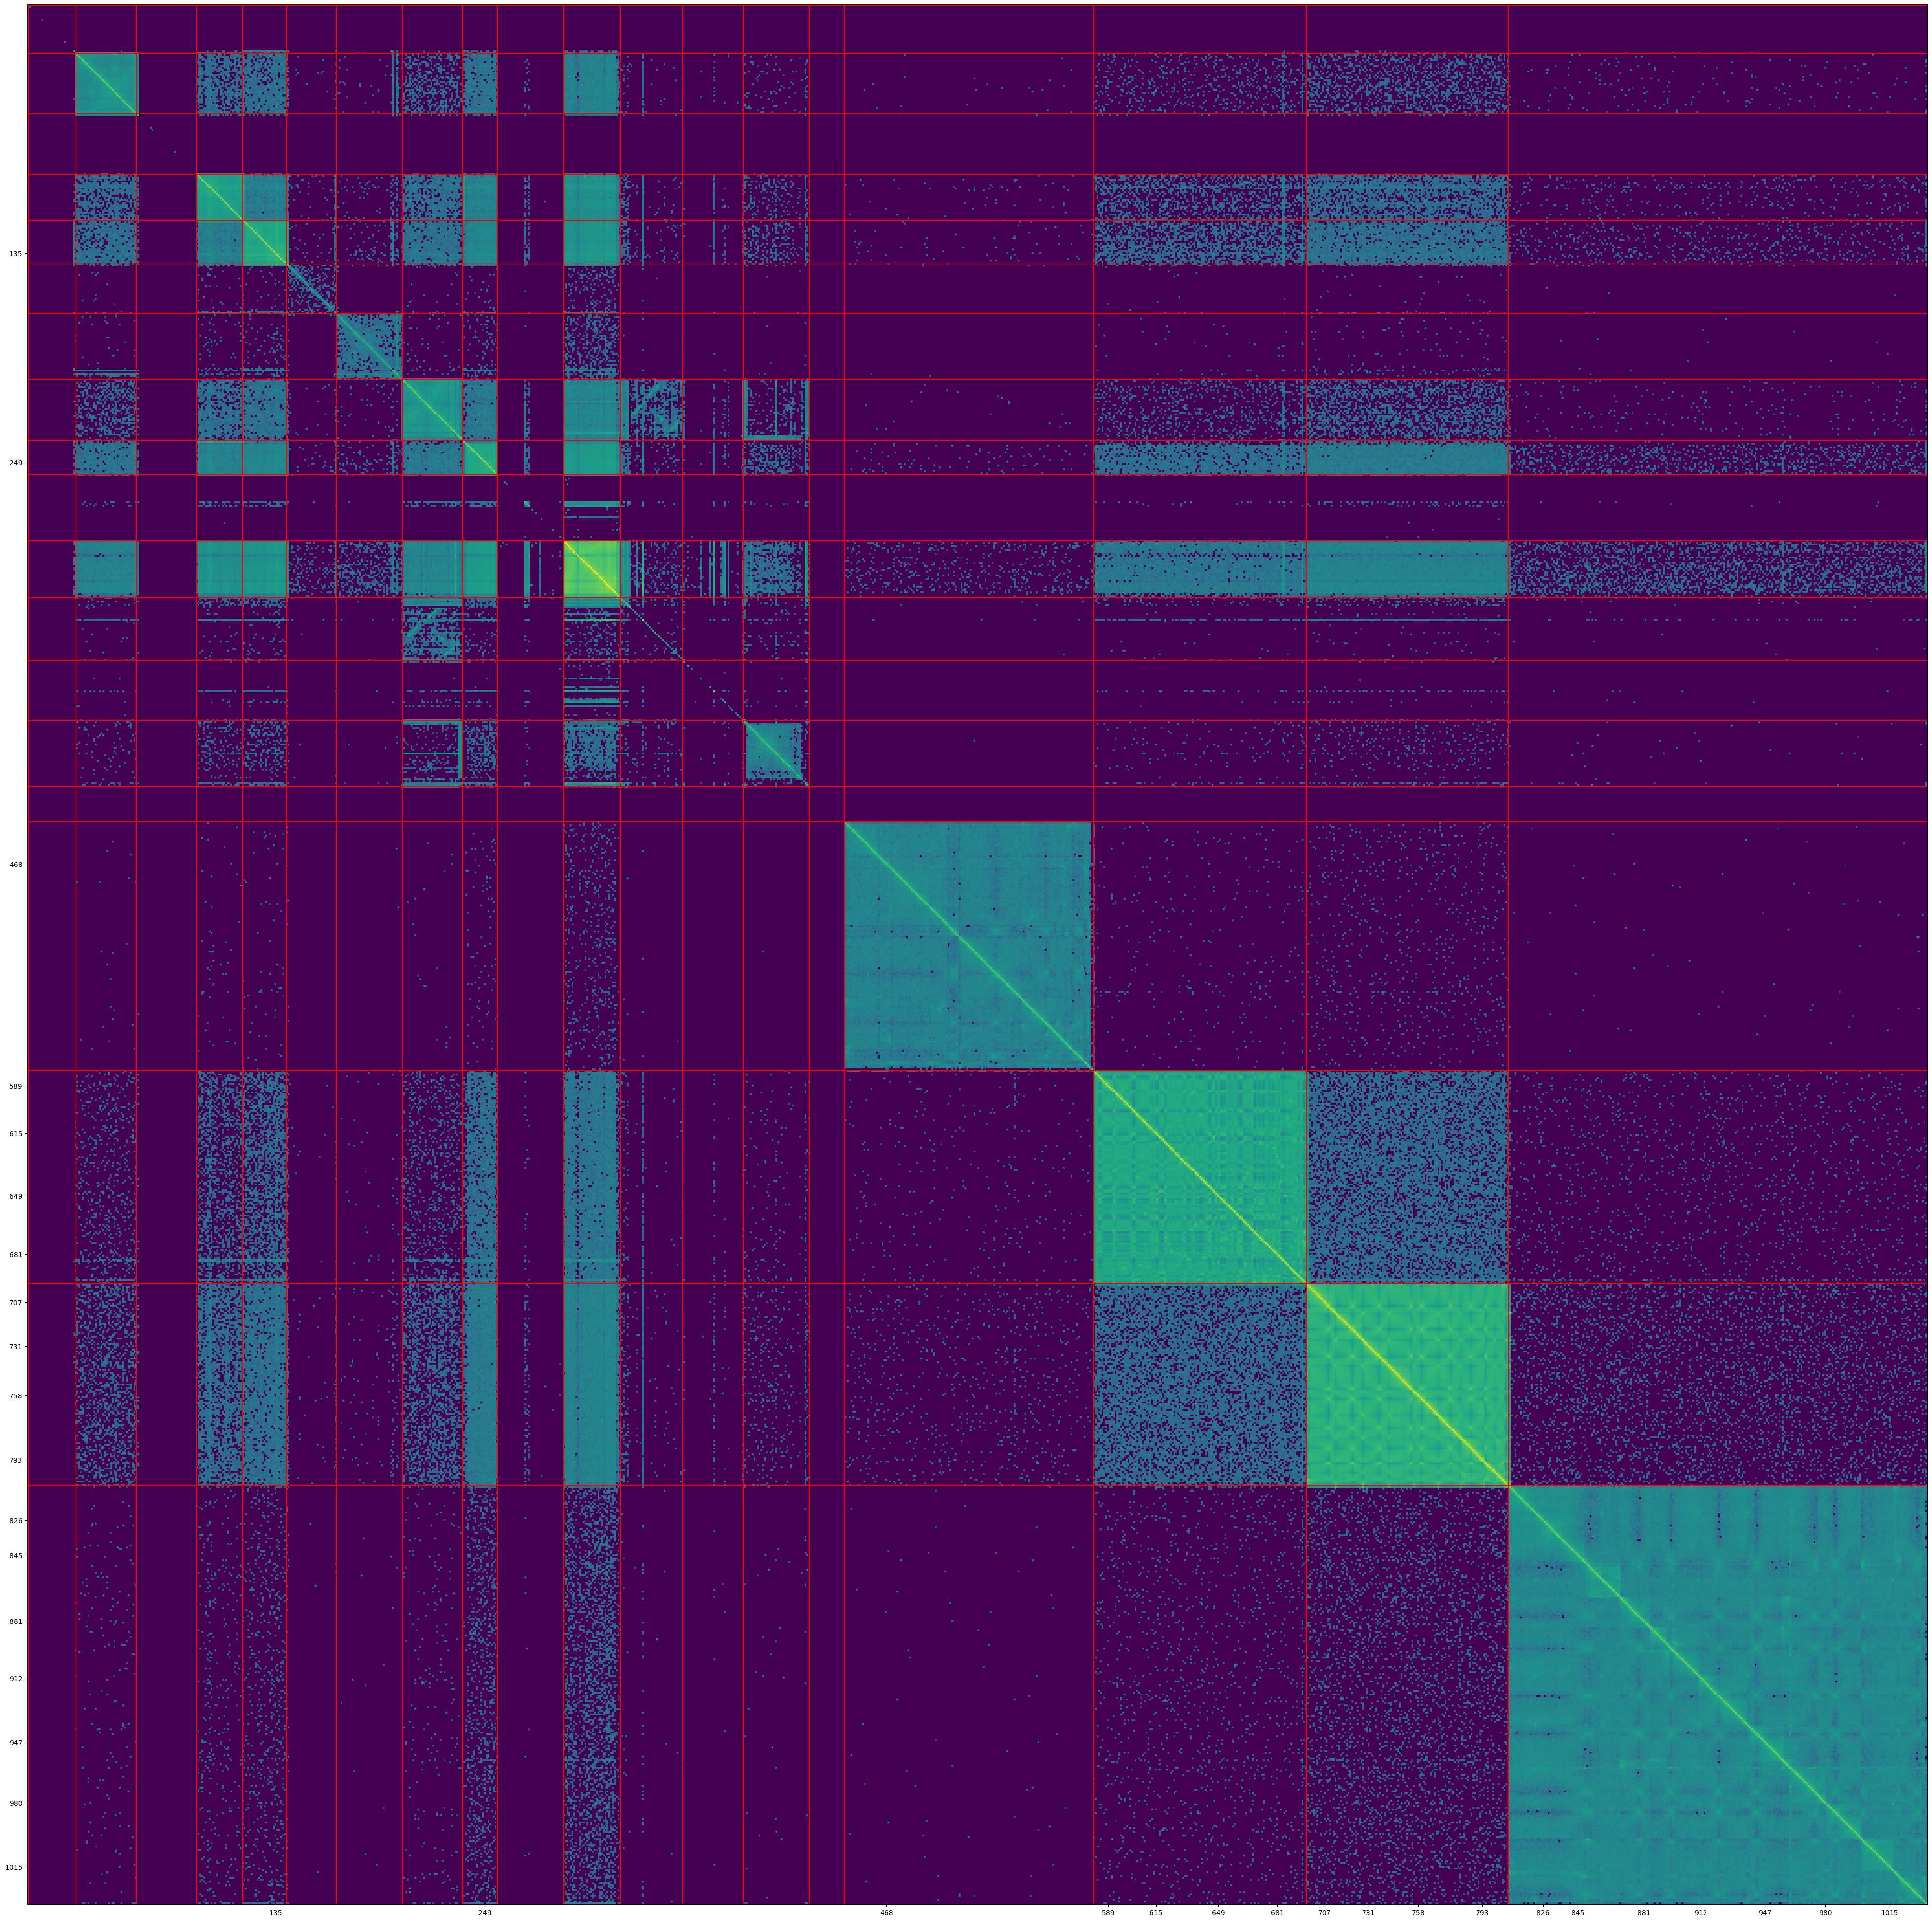

<Figure size 640x480 with 0 Axes>

In [9]:
#tranform a sparse matrix to a dense matrix
def sparse2dense(submat, bin=1):
    if (submat.shape[0]>10):
        a=np.array([submat['row'], submat['column'], submat['values']], dtype = 'float')
        A=np.transpose(np.array([a[0,:],a[1,:],a[2,:]]))
        A=np.int_(A)
        A=np.concatenate((A,np.transpose(np.array([A[:,1],A[:,0],A[:,2]]))), axis=0)
        raw_map = sparse.coo_matrix( (A[:,2], (A[:,0],A[:,1])))
        binned_map = sparse.csr_matrix.todense(HiCtoolbox.bin2d(raw_map,bin,bin))
    else: 
        print("Pas suffisemment de contacts")
        binned_map=np.array([0, 0, 0], dtype = 'float')
    return(binned_map)


def plot_submat(binned_map, path):
    plt.figure(1, figsize=(50, 50))
    plt.imshow(np.log(binned_map+0.001))
    plt.xticks([135, 249, 468, 589, 615, 649, 681, 707, 731, 758, 793, 826, 845, 881, 912, 947, 980, 1015])
    plt.yticks([135, 249, 468, 589, 615, 649, 681, 707, 731, 758, 793, 826, 845, 881, 912, 947, 980, 1015])
    for i in tab['genome_len_bin']:
        plt.axvline(x=i, color='red')
        plt.axhline(y=i, color='red')
    plt.show()
    plt.savefig(path)   

binned_map=sparse2dense(submat, 1000)

plot_submat(binned_map, './HiCmatrix.png')

**Plot de la matrice normalisée**

SCN : 100%|██████████| 10/10 [00:00<00:00, 274.93it/s]


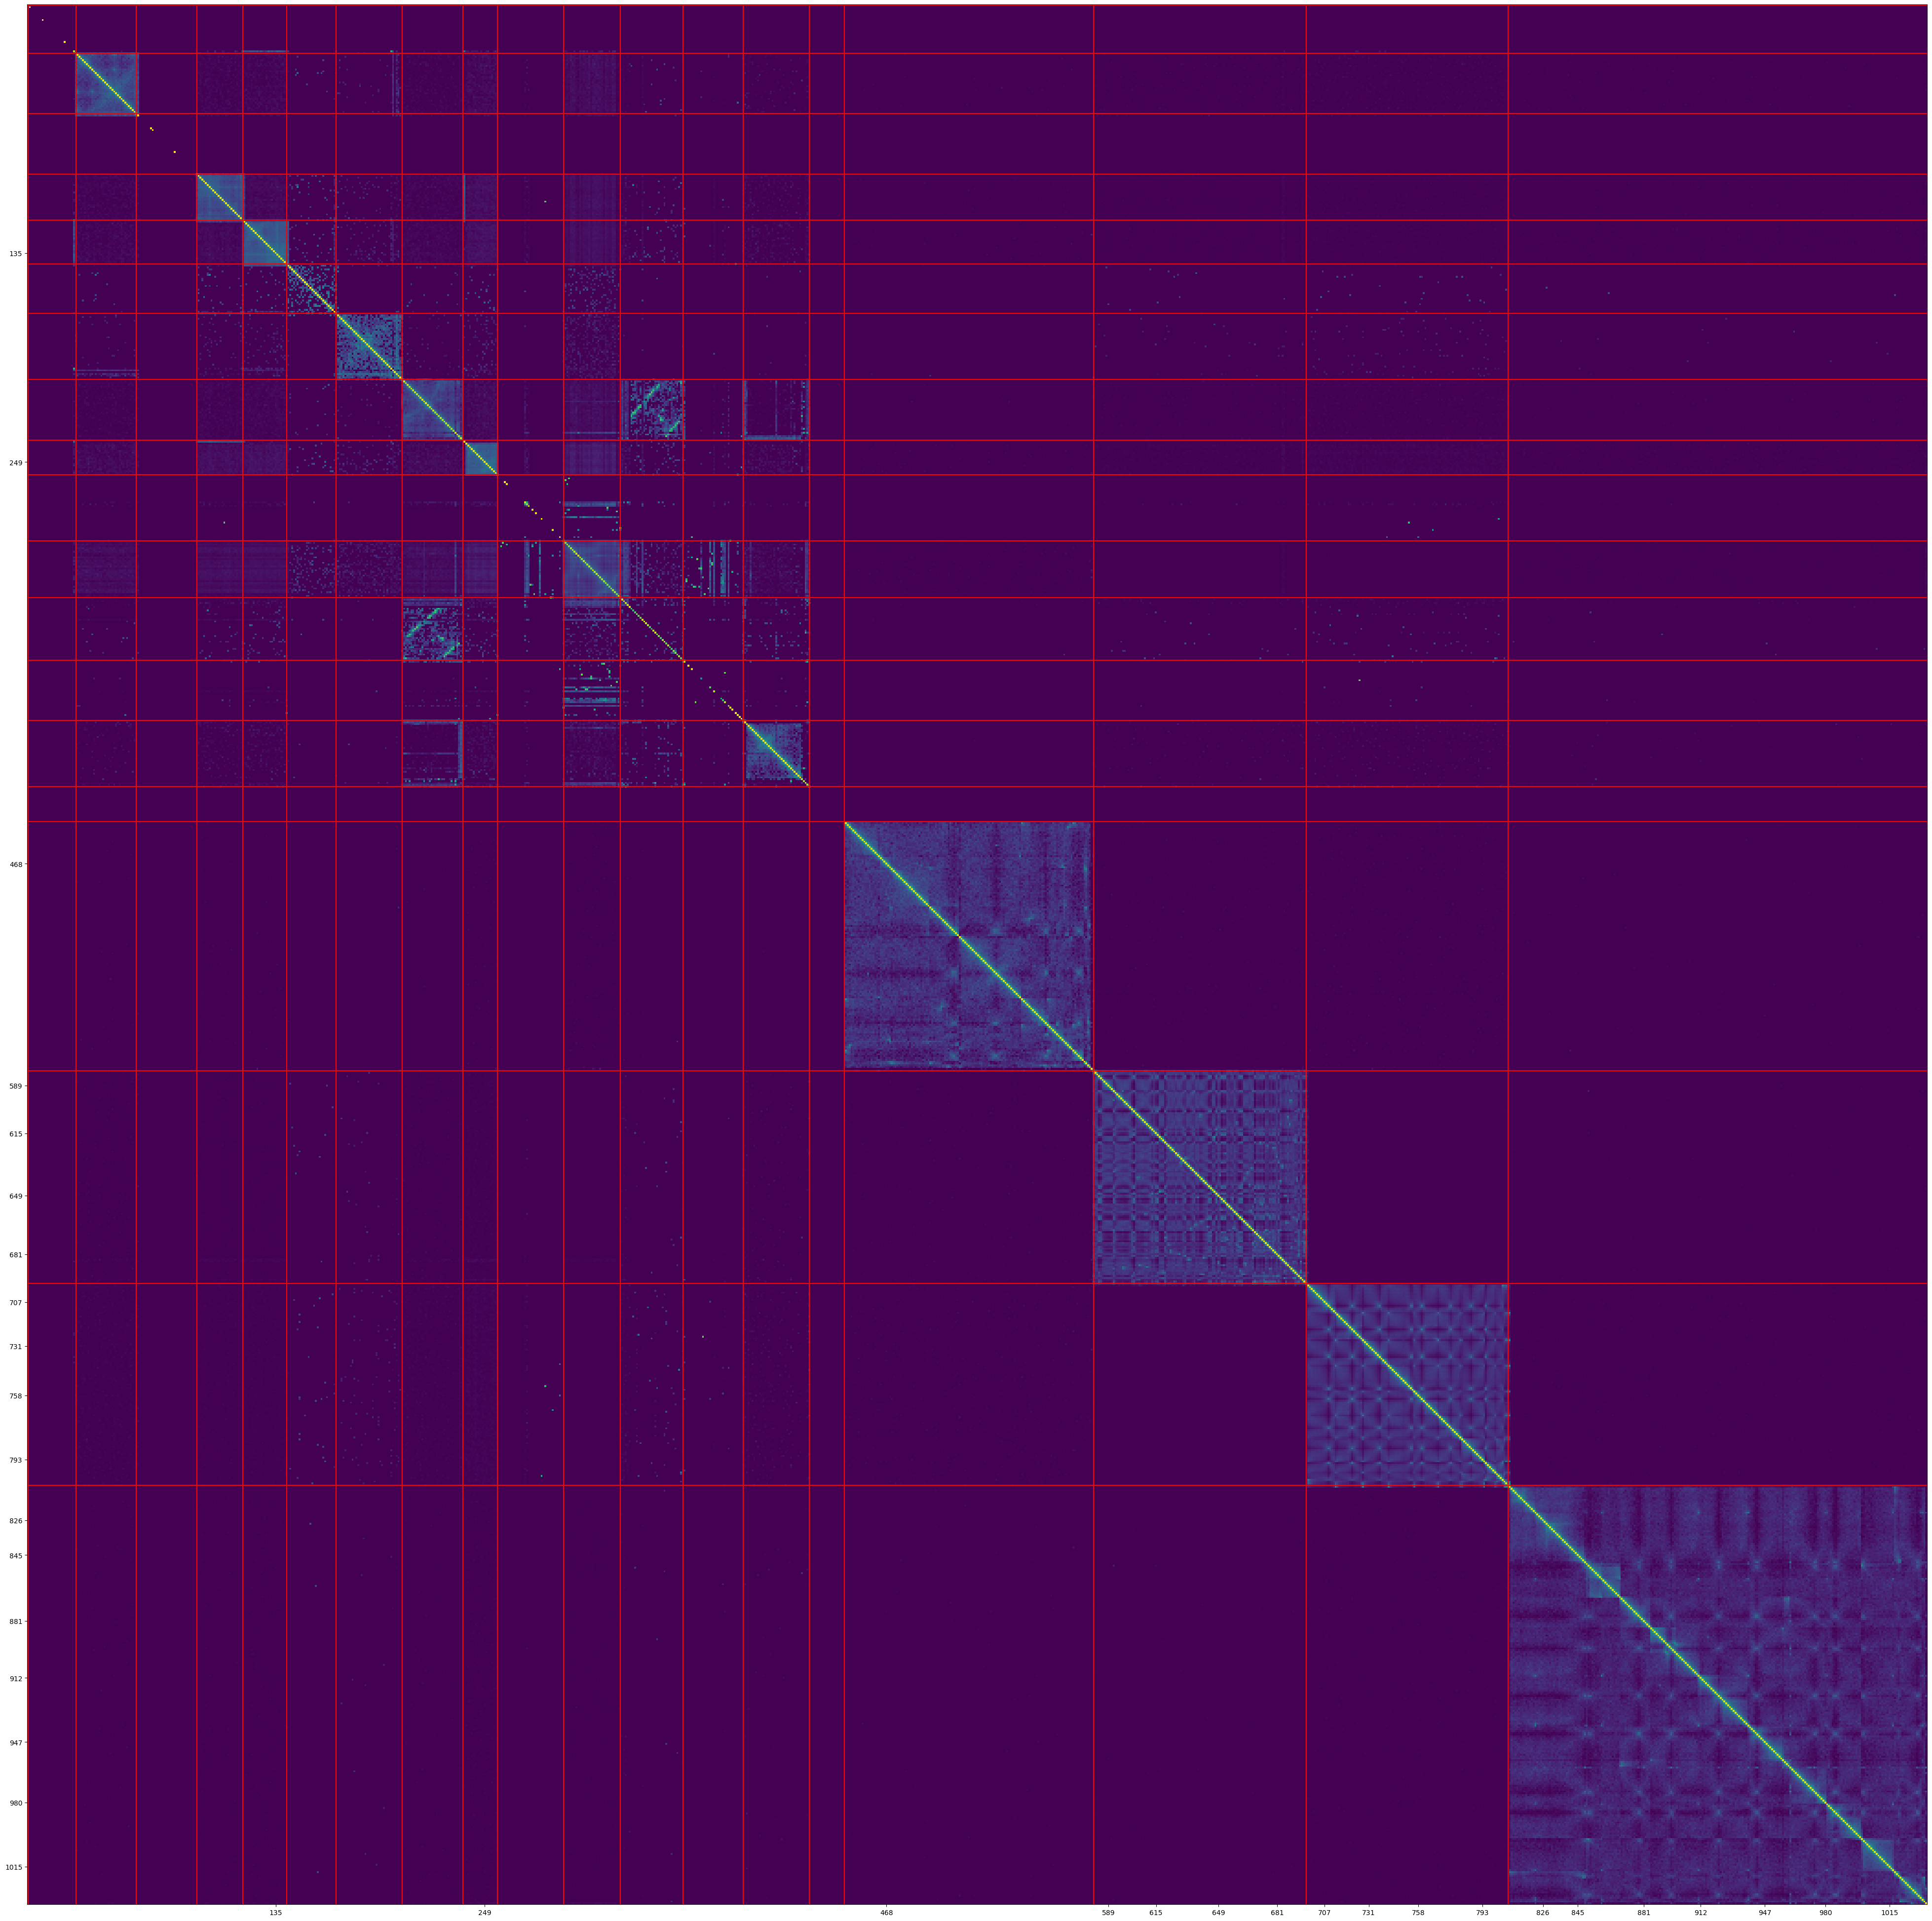

<Figure size 640x480 with 0 Axes>

In [10]:
norm_map = HiCtoolbox.SCN(sparse.coo_matrix(binned_map), max_iter=10)

rebinned_map=norm_map.todense()

plot_submat(rebinned_map, './HiCmatrix.png')

# 3. Bacteries

In [11]:
# Liste des espèces de bactéries (à conserver)
yeast_nb = ["BB", "Y1", "Y2", "Y3"]
mask = ~frag['sp_nb'].isin(yeast_nb)
bact_species = frag[mask]['species'].unique()

print(bact_species)
len(bact_species)

['Lentilactobacillus parabuchneri' 'Lacticaseibacillus paracasei'
 'Schleiferilactobacillus harbinensis' 'Liquorilactobacillus nagelii'
 'Liquorilactobacillus ghanensis' 'Liquorilactobacillus satsumensis'
 'Lentilactobacillus hilgardii' 'Gluconobacter oxydans'
 'Oenococcus sicerae' 'Novacetimonas hansenii' 'Acetobacter fabarum'
 'Gluconobacter albidus' 'Komagataeibacter xylinus'
 'Gluconobacter cerinus' 'Leuconostoc mesenteroides']


15

In [12]:
# filter rows based on list values
mask = ~frag['species'].isin(bact_species)
frag_bact = frag[mask].ID

print(frag_bact)

445444      445444
445445      445445
445446      445446
445447      445447
445448      445448
            ...   
1034873    1034873
1034874    1034874
1034875    1034875
1034876    1034876
1034877    1034877
Name: ID, Length: 589434, dtype: int64


In [13]:
bin=100

#function which extract a submatrix for a given contig from 2 global matrix and frag files
def make_submat_bact(species, matrix, frag):
    mask = frag['species'].isin(species)
    toselect = frag[mask].ID
    tmp0=matrix.loc[matrix['row'] > min(toselect)]
    tmp1=tmp0.loc[tmp0['row'] < max(toselect)]
    tmp2=tmp1.loc[tmp1['column'] > min(toselect)]
    submat=tmp2.loc[tmp2['column'] < max(toselect)]
    submat.loc[:,'row']=submat.loc[:,'row'] - min(toselect)
    submat.loc[:,'column']=submat.loc[:,'column'] - min(toselect)
    return(submat)


subbmat=make_submat_bact(bact_species, matrix, frag)

binned_map=sparse2dense(subbmat, bin)

norm_map = HiCtoolbox.SCN(sparse.coo_matrix(binned_map), max_iter=10)

rebinned_map=norm_map.todense()

SCN : 100%|██████████| 10/10 [00:00<00:00, 97.47it/s]


In [14]:
tab_bact = tab[tab['species'].isin(bact_species)]

zero=np.array(tab_bact['genome_len'])[0]

tab_bact['genome_len']=tab_bact['genome_len']-zero
tab_bact['genome_len_bin']=np.round(tab_bact['genome_len']/bin)

print(tab_bact)

                                species  genome_len  genome_len_bin  \
0       Lentilactobacillus parabuchneri           0             0.0   
1          Lacticaseibacillus paracasei       25547           255.0   
2   Schleiferilactobacillus harbinensis       59340           593.0   
3          Liquorilactobacillus nagelii       91855           919.0   
4        Liquorilactobacillus ghanensis      117246          1172.0   
5      Liquorilactobacillus satsumensis      141248          1412.0   
6          Lentilactobacillus hilgardii      168384          1684.0   
7                 Gluconobacter oxydans      203752          2038.0   
8                    Oenococcus sicerae      236721          2367.0   
9                Novacetimonas hansenii      255618          2556.0   
10                  Acetobacter fabarum      291553          2916.0   
11                Gluconobacter albidus      323107          3231.0   
12             Komagataeibacter xylinus      357223          3572.0   
13    

/tmp/ipykernel_1649554/3045437625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tab_bact['genome_len']=tab_bact['genome_len']-zero
/tmp/ipykernel_1649554/3045437625.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tab_bact['genome_len_bin']=np.round(tab_bact['genome_len']/bin)


In [15]:
ctg_bact = ctg[ctg['species'].isin(bact_species)]

zero=np.array(ctg_bact['cumul_length'])[0]

ctg_bact['cumul_length']=ctg_bact['cumul_length']-zero
ctg_bact['cumul_length_bin']=ctg_bact['cumul_length']/bin

print(ctg_bact)

                                chrom   length  n_frags  cumul_length  index  \
0    B10_contig_2|kraken:taxid|152331    15138      152             0      0   
1    B10_contig_1|kraken:taxid|152331  2454889    24549           152      1   
2    B10_contig_3|kraken:taxid|152331    84524      846         24701      2   
3     B11_contig_11|kraken:taxid|1597    11019      111         25547      3   
4      B11_contig_1|kraken:taxid|1597     2246       23         25658      4   
..                                ...      ...      ...           ...    ...   
100    B6_contig_1|kraken:taxid|38307  3185936    31860        391386    100   
101    B6_contig_2|kraken:taxid|38307    36217      363        423246    101   
102    B6_contig_3|kraken:taxid|38307   218920     2190        423609    102   
103     B7_contig_2|kraken:taxid|1245    37365      374        425799    103   
104     B7_contig_1|kraken:taxid|1245  1927069    19271        426173    104   

    sp_nb                          spec

/tmp/ipykernel_1649554/3566957031.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctg_bact['cumul_length']=ctg_bact['cumul_length']-zero
/tmp/ipykernel_1649554/3566957031.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctg_bact['cumul_length_bin']=ctg_bact['cumul_length']/bin


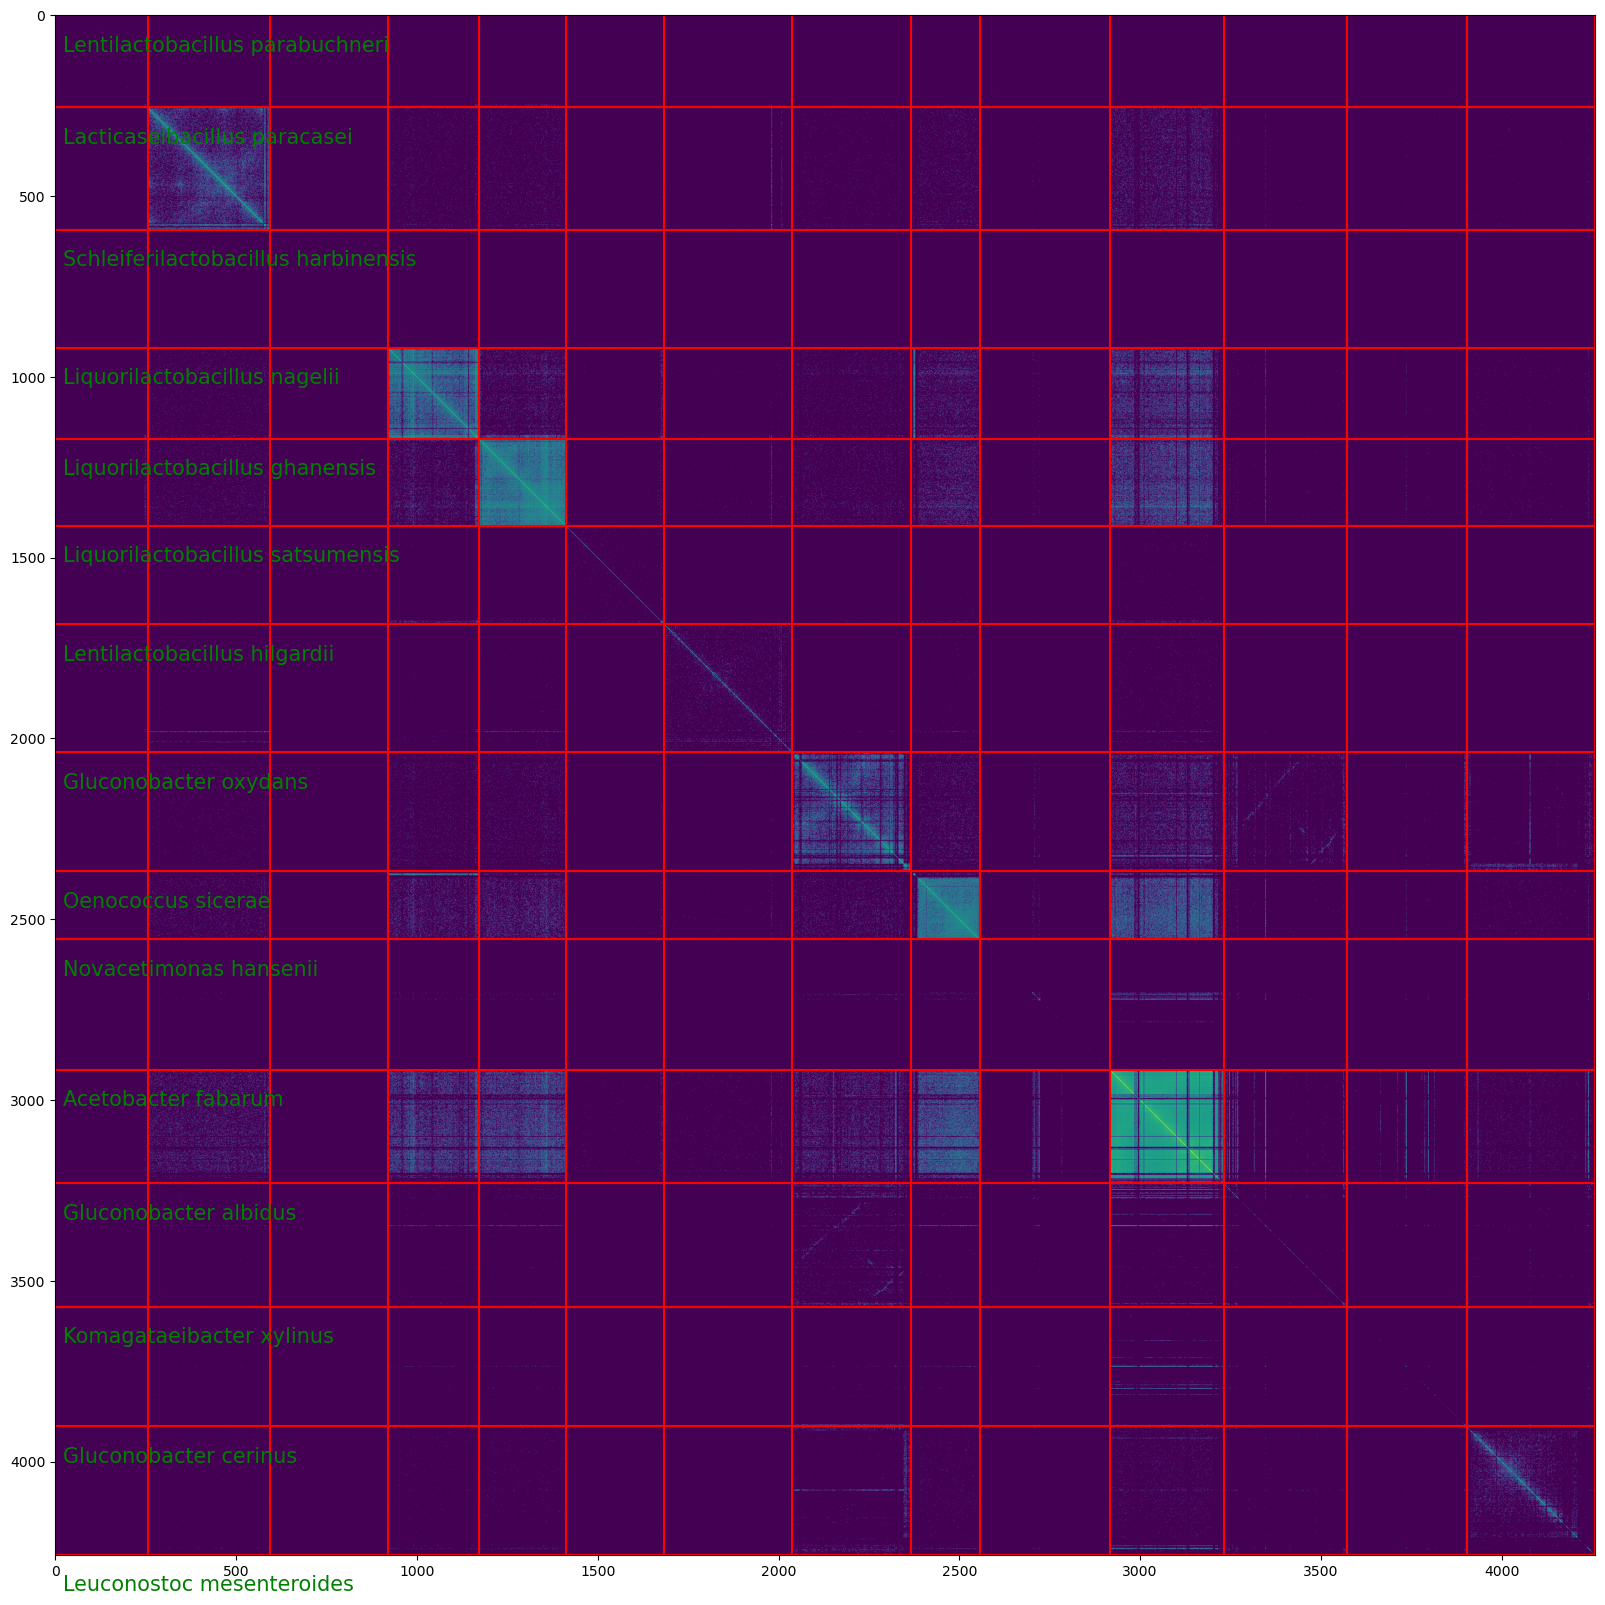

In [16]:
## Juste pour faire la carte plus petite
def plot_submat(binned_map):
    plt.figure(1, figsize=(20, 20))
    plt.imshow(np.log(binned_map+0.001))
    #for i in ctg_bact['cumul_length_bin']:
    #    plt.axvline(x=i, color='orange')
   # plt.axhline(y=3308, color='orange')
    for i in tab_bact['genome_len_bin']:
        plt.axvline(x=i, color='red')
        plt.axhline(y=i, color='red')
    for i in range(0, len(tab_bact['species'])):
        plt.text(y=np.array(tab_bact['genome_len_bin'])[i]+100, x=20, s=np.array(tab_bact['species'])[i], color="green", size=15)
    plt.show()


plot_submat(binned_map)

# 4. Phages

**Génomes de phages intacts**

In [18]:
temp = phaster[phaster['completeness'] == "intact"][["species", "position", "phage"]].reset_index(drop = True)
temp = temp.merge(tab_bact[['species', 'genome_len_nucl']], on = "species")


temp[['start', 'end']] = temp['position'].str.split('-', expand=True)
temp['start'] = pd.to_numeric(temp['start'])
temp['end'] = pd.to_numeric(temp['end'])
temp['genome_len_nucl'] = pd.to_numeric(temp['genome_len_nucl'])
temp[['start', 'end']] += temp['genome_len_nucl']
print(temp)

                                species         position  \
0                Novacetimonas hansenii  3286637-3310166   
1          Lacticaseibacillus paracasei  1093558-1151879   
2          Lacticaseibacillus paracasei  2429223-2443172   
3       Lentilactobacillus parabuchneri  1640626-1685496   
4       Lentilactobacillus parabuchneri      47051-71735   
5             Leuconostoc mesenteroides  1463733-1501937   
6        Liquorilactobacillus ghanensis        444-10032   
7        Liquorilactobacillus ghanensis  1087108-1099229   
8      Liquorilactobacillus satsumensis        128-42452   
9                    Oenococcus sicerae        642-38002   
10                   Oenococcus sicerae    217299-257724   
11  Schleiferilactobacillus harbinensis        283-16306   

                                    phage  genome_len_nucl  start  end  
0           PHAGE_Entero_SfI_NC_027339(8)          1964434    NaN  NaN  
1              PHAGE_Lactob_T25_NC_048625         13527305    NaN  NaN  


In [19]:
print(tab_bact)

                                species  genome_len  genome_len_bin  \
0       Lentilactobacillus parabuchneri           0             0.0   
1          Lacticaseibacillus paracasei       25547           255.0   
2   Schleiferilactobacillus harbinensis       59340           593.0   
3          Liquorilactobacillus nagelii       91855           919.0   
4        Liquorilactobacillus ghanensis      117246          1172.0   
5      Liquorilactobacillus satsumensis      141248          1412.0   
6          Lentilactobacillus hilgardii      168384          1684.0   
7                 Gluconobacter oxydans      203752          2038.0   
8                    Oenococcus sicerae      236721          2367.0   
9                Novacetimonas hansenii      255618          2556.0   
10                  Acetobacter fabarum      291553          2916.0   
11                Gluconobacter albidus      323107          3231.0   
12             Komagataeibacter xylinus      357223          3572.0   
13    

In [20]:
def plot_submat(binned_map):
    plt.figure(1, figsize=(20, 20))
    plt.imshow(np.log(binned_map+0.001))
    for i in tab_bact['genome_len_bin']:
        plt.axvline(x=i, color='red')
        plt.axhline(y=i, color='red')
    for i in range(0, len(tab_bact['species'])):
        plt.text(y=np.array(tab_bact['genome_len_bin'])[i]+100, x=20, s=np.array(tab_bact['species'])[i], color="green", size=15)
    for i in 
    plt.show()


    

SyntaxError: invalid syntax (308924122.py, line 9)